Link to Google Colab version (Compute this script in the cloud): https://colab.research.google.com/drive/1Q0Er4ukLmIa-nCeL-n4_g8vryoDkdU4c?usp=sharing

# Phase Diagram of the Quark-Meson Model using the Kurganov-Tadmor Finite Volume Scheme

---

An example: How to solve FRG flow equations with finite volume schemes

---
*Author: Phillip Lakaschus*

In this notebook the Kurganov-Tadmor scheme (KT scheme) is adapted, which is based on this paper [3]: [Link to paper](https://www.cscamm.umd.edu/people/faculty/tadmor/pub/central-schemes/Kurganov-Tadmor.JCP-00I.pdf)

In that paper the authors introduce a high-resolution central scheme for convection-diffusion(-reaction) equations of the form

<img src="https://drive.google.com/uc?export=view&id=14cxh040Z80J_HJFMScMwuot6aQzNsX1P">

Therefore, if we are able to recast our flow equation into this form, we should be able to use the scheme introduced in that paper.

#The flow equation for $U_k$


The flow equation of the effective potential of the quark-meson model (QMM) in the local potential approximation (LPA) is given as ([tripolt et al. 2013](https://arxiv.org/abs/1311.0630), [Schaefer et al. 2004](https://arxiv.org/abs/nucl-th/0403039v2)):

<img src="https://drive.google.com/uc?export=view&id=1hPC_smIwuWLG5nIaibAgjijMFC1KjeEt">,

where

<img src="https://drive.google.com/uc?export=view&id=1rOeEagDn-vhe1UydVNod9j-YgLUQUwAh">


<img src="https://drive.google.com/uc?export=view&id=1Zac2YeUNb6EX-Xjj_znGrLTcp0SRmk9r">


Substituting $k = \Lambda e^{-t}$ und taking the derivative $\partial_\rho$ ($\rho = \phi^2$) yields

\begin{equation}
\partial_t \partial_\rho U = - \partial_\rho \left[\dfrac{1}{2}\Lambda e^{-t} I_\sigma(U', U'') + \dfrac{N-1}{2}\Lambda e^{-t} I_\pi(U') - N_f N_c \Lambda e^{-t} I_\psi\right] \, . 
\end{equation}

Now let's rename $\partial_\rho U \equiv V$ yielding the new flow equation for the derivative of the effective potential:

\begin{equation}
\partial_t V = - \left[\dfrac{N-1}{2}\Lambda e^{-t} \partial_\rho I_\pi(V) + \dfrac{1}{2}\Lambda e^{-t} \partial_\rho I_\sigma(V, V')  - N_f N_c \Lambda e^{-t} \partial_\rho I_\psi\right] \, . \, (1)
\end{equation}

On the rhs the first term is the **flux** term, the second one the **diffusion** term and the third one the **source** term.

In this form we are able to use the KT scheme to solve the flow-equation.

Now, we just have to look up the scheme in  Ref. [[KT](https://www.cscamm.umd.edu/people/faculty/tadmor/pub/central-schemes/Kurganov-Tadmor.JCP-00I.pdf)]. Here, we use the **semi-discrete** scheme:
<img src="https://drive.google.com/uc?export=view&id=1QQ25FvqEhbNJoyi8gm31mZO89Uui4-O5">

<img src="https://drive.google.com/uc?export=view&id=1esWg1qVhEG7kB60uTq7i7msh0klA6kg-">

$(u_x)_j$ are defined via the minmod limiter:

<img src="https://drive.google.com/uc?export=view&id=12JWXzlDaksiohLgd99R6gkJW6bpsXwhb">

$a_{j\pm 1}$ are the local propagation speeds which are given as

\begin{equation}
a_{j+1/2} = \textrm{max}\lbrace{|f'(u^-_{j+1/2})|, |f'(u^+_{j+1/2})|}\rbrace \, .
\end{equation}

In Ref. [[KT](https://www.cscamm.umd.edu/people/faculty/tadmor/pub/central-schemes/Kurganov-Tadmor.JCP-00I.pdf)] it is not explained how to treat the source term. Fortunately, incorporating the source term is rather straightforward. We can simply use the integral form of the differential equation to see how the source term is added at each grid point:

\begin{equation}
  \partial_t u(x, t) = \partial_x S(x, t) 
\end{equation}
\begin{equation}
  \partial_t \int_{x_{i-1/2}}^{x_{i+1/2}} u(x, t) dx = \int_{x_{i-1/2}}^{x_{i+1/2}} \partial_x S(x, t) dx
\end{equation}
\begin{equation}
  \partial_t \overline{u} \, dx = S(x_{i+1/2}, t) - S(x_{i-1/2}, t)
\end{equation}

\begin{align}
\rightarrow \partial_t \overline{u} = \dfrac{S(x_{i+1/2}, t) - S(x_{i-1/2}, t)}{dx}
\end{align}

Alternatively, one can simply calculate the derivative explicitly.

Now we have everything together to code the solver for the flow equation.



# Coding the solver


---

In [2]:
!pip install findiff==0.7.0

# Import libraries
import time
import numpy as np                  # needed for efficient array manipulation
import matplotlib.pyplot as plt     # plot library
from scipy.integrate import odeint  # import the time integrator
from scipy import integrate         
from findiff import FinDiff         # finite difference library              

  Using cached findiff-0.7.0.tar.gz (15 kB)
  Created wheel for findiff: filename=findiff-0.7.0-py3-none-any.whl size=10903 sha256=5a4b9728138b10d4c7585f0851f4fb4d301300f51c9d690bafc12cdfe8900bd1
  Stored in directory: c:\users\phillip\appdata\local\pip\cache\wheels\69\97\d8\47a803607c5e38495942d6e11c3e40197334eabb08340fe6be
Successfully built findiff
  Attempting uninstall: findiff
    Found existing installation: findiff 0.8.9
    Uninstalling findiff-0.8.9:
      Successfully uninstalled findiff-0.8.9


Let's define all functions that are needed for the flow equation:

In [3]:
# Define energies, see also Eq. B5
def Esig(x, u, ux, t):
  return np.sqrt(cutoffr**2*np.exp(-2*t) + 2*u + 4*x*ux/dx)

def Epion(u, t):
  return np.sqrt(cutoffr**2*np.exp(-2*t) + 2*u)

def Epsi(x, t):
  return np.sqrt(cutoffr**2*np.exp(-2*t) + h**2*x)

# convection flux
def flux(u, t, T):
  Ep = Epion(u, t)
  return (Nf-1)/(12*np.pi**2)*cutoffr**5*np.exp(-5*t)*(1+2/(np.exp(Ep/T) - 1))/Ep

# characteristic velocity/local propagation speed
def char(u, t, T):
  Ep = Epion(u, t)
  return 1/2*(Nf-1)/(6*np.pi**2)*cutoffr**5*np.exp(-5*t)*(-2/(T*Ep**2)*np.exp(Ep/T)/(np.exp(Ep/T) - 1)*1/(np.exp(Ep/T) - 1) \
                                                         - 1/Ep**3*(1+2/(np.exp(Ep/T) - 1)))

# diffusion term
def diff(x, u, ux, t, T):
  Es = Esig(x, u, ux, t)
  return -1/2*cutoffr**5/(6*np.pi**2)*np.exp(-5*t)*(1+2/(np.exp(Es/T) - 1))/Es

# source term
def src(x, t, T, mu):
  Eps = Epsi(x, t)
  return 1/np.pi**2*cutoffr**5*np.exp(-5*t)*(1/Eps*(np.tanh((Eps - mu)/(2*T)) + np.tanh((Eps + mu)/(2*T)))) 

# source term, derivative already taken
def src2(x, t, T, mu):
  Eps = Epsi(x, t)
  return 1/np.pi**2*cutoffr**5*np.exp(-5*t)*h**2/(4*Eps**3*T)*( Eps*( 1/(np.cosh((Eps - mu)/(2*T))**2 + 1/(np.cosh((Eps + mu)/(2*T))**2 )) ) - 2*T*\
                                                               (np.tanh((Eps - mu)/(2*T)) + np.tanh((Eps + mu)/(2*T))))

# generalised minmod limiter
def gen_minmod(a, b, c):
  th = 1
  maximum = np.maximum(th*a, np.maximum(b, th*c))
  minimum = np.minimum(th*a, np.minimum(b, th*c))
  hs_pos = np.heaviside(a, 1)*np.heaviside(b, 1)*np.heaviside(c, 1)
  hs_neg = np.heaviside(-a, 1)*np.heaviside(-b, 1)*np.heaviside(-c, 1)
  return minimum*hs_pos + maximum*hs_neg

def pion_mass(u, min_pos):
    m_pi = np.sqrt(2*d_dx(u)[min_pos])*cutoff
    return m_pi

def sigma_mass(xc, u, min_pos):
    m_sigma = np.sqrt(2*d_dx(u)[min_pos] + 4*xc[min_pos]*d2_dx2(u)[min_pos])*cutoff
    return m_sigma

Eq. (1) which needs to be integrated:

In [4]:
def dudt(u, t, T, mu):
  low_bnd, up_bnd = u[0]-(u[1] - u[0]), u[-1]+(u[-1]-u[-2]) # ghost cells: linearly extrapolated potential
  u = np.append(low_bnd, np.append(u, up_bnd)) # add boundaries to potential
  
  # minmod limiter
  limiter = gen_minmod((u[1:-1] - u[:-2])/dx, (u[2:] - u[:-2])/(2*dx),  (u[2:] - u[1:-1])/dx)
  
  # definition of intermediate values, u_(j-1/2), see Eq. 4.5
  uLForw = u[0] + (u[1] - u[0])/2 
  uLCent = u[1:-1] + dx/2*limiter
  uL = np.append(uLForw, uLCent)
  
  # definition of intermediate values, u_(j+1/2)
  uRBack = u[-1] - (u[-1] - u[-2])/2
  uRCent = u[1:-1] - dx/2*limiter
  uR = np.append(uRCent, uRBack)
  
  # calculate the propagation speeds
  charL = char(uL, t, T)
  charR = char(uR, t, T)
  prop = (np.abs(charL) >= np.abs(charR)).astype(int)*np.abs(charL) \
       + (np.abs(charL) < np.abs(charR)).astype(int)*np.abs(charR)
  
  # see Eq. 4.4
  fu_interface = (flux(uL, t, T) + flux(uR, t, T))/2 - prop/2*(uR - uL)

  # diffusion term; see Eq. 4.14    
  Pp = 1/2*(diff(xcR[:-1], u[1:-1], u[2:] - u[1:-1], t, T) + diff(xcR[1:], u[2:], u[2:] - u[1:-1], t, T))
  Pm = 1/2*(diff(xcL[:-1], u[:-2], u[1:-1] - u[:-2], t, T) + diff(xcL[1:], u[1:-1], u[1:-1] - u[:-2], t, T))

  #source = src(x, t, T, mu)
  
  # complete flow equation
  dudt =  (fu_interface[:-1] - fu_interface[1:])/dx + (Pp - Pm)/dx + src2(xc, t, T, mu) # + (source[1:] - source[:-1])/dx #
  return dudt

We only solve the derivative of the effective potential.
The following function reconstructs the effective potential from the derivative:

In [5]:
def construct_potential(x, u):
    return integrate.cumtrapz(u, x, initial=0)

We use scipy.odeint to integrate the flow equation. 

In [6]:
def solve(T, mu):
    print((T, mu))
    return odeint(dudt, u0, t, args=(T, mu), mxstep=200000, rtol= 1e-12, atol=1e-12)

# Main

In [7]:
if __name__ == "__main__":
  # All quan,tities are rendered dimensionless with respect to the cutoff
  cutoff = 1000
  cutoffr = 1  # rescaled cutoff; Set cutoffr = 1000 and cutoff = 1 for dimensionful calculation
  
  N = 80 # number of gridpoints
  xmax = 140**2/cutoff**2
  x = np.linspace(0, xmax, N+1)
  N_t = 100
  t_max = 3.5 # This corresponds to roughly k = 30 MeV
  t = np.linspace(0, t_max, N_t)
  dx = x[1] - x[0]

  xc = 0.5*np.array(x[:-1]+x[1:]) # array with values in-between grid points
  xcL = np.append(xc[0] - dx, xc)
  xcR = np.append(xc, xc[-1] + dx)
  
  # define derivatives, later used the determine the pion and sigma mass
  acc = 2
  d_dx = FinDiff(0, dx, acc = acc)
  d2_dx2 = FinDiff(0, dx, 2, acc = acc)

  # Model parameters
  Nf = 4  # N of O(N), not number of flavors
  m_lam, lam, c, h = 794/cutoff, 2, 1750000/cutoff**3, 3.2 # taken from Ref. [1]

  u0 = (1/2*m_lam**2 + 1/2*lam*xc) # derivative of initial potential
  v0 = (1.0/2.0*m_lam**2*xc + lam/4.0*xc**2) # initial effective potential
  expl_sym_br = c*np.sqrt(xc) # explicit symmetry breaking term

Test: The integral of u0 must the same as v0

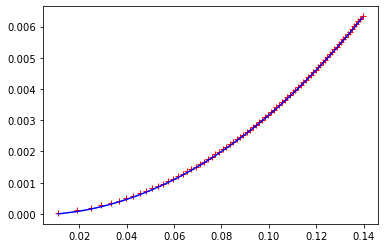

In [8]:
  plt.plot(np.sqrt(xc), v0, "+", color="red")
  plt.plot(np.sqrt(xc), construct_potential(xc, u0), color="b")
  plt.show()

Now let's solve the flow equation for $T = 5$ MeV and $\mu = 0$.

In [9]:
  start = time.time()  

  sol_example = solve(5/cutoff, 0/cutoff)

  print("Duration: "+str(time.time()-start)[:2]+" s")

(0.005, 0.0)
Duration: 2. s


**Plot the result:**

In [10]:
"""Taken from https://colab.research.google.com/drive/131wXGA8h8d7llSZxZJ6R4e8nz0ih1WPG#scrollTo=5zVG8JcR4CS2"""
from matplotlib import animation, rc
from IPython.display import HTML

# First set up the figure, the axes, and the plot element
fig, ax = plt.subplots()
plt.close()
ax.set_xlim(( 0, 0.12))
ax.set_ylim((-0.0002, 0.001))
line2, = ax.plot([], [], lw=2)

# animation function: this is called sequentially
def animate(i):
  line2.set_data(np.sqrt(xc), construct_potential(xc, sol_example[i]))
  return (line2,)

anim = animation.FuncAnimation(fig, animate, frames=N_t, blit=True)

rc('animation', html='jshtml')
anim

A closer look at the IR potential:

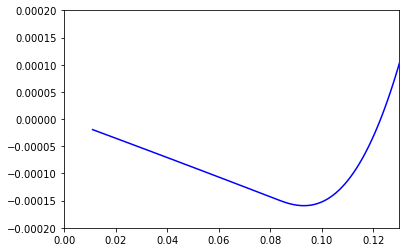

Minimum of the potential:  92.60129588726066
Pion mass:  138.41568621116826
Sigma mass:  511.7950365398092


In [11]:
axes = plt.gca()
axes.set_xlim([0.,.13])
axes.set_ylim([-0.0002, 0.0002])
plt.plot(np.sqrt(xc), construct_potential(xc, sol_example[-1]) - expl_sym_br, c='b')
plt.show()
u = construct_potential(xc, sol_example[-1])
min_pos = np.argmin(u - expl_sym_br)
f_pi = np.sqrt(min_pos*dx)*cutoff
m_pi = pion_mass(u, min_pos)
m_sig = sigma_mass(xc, u, min_pos)
print("Minimum of the potential: ", f_pi)
print("Pion mass: ", m_pi)
print("Sigma mass: ", m_sig)

# Phase diagram of the QMM

**Warning:** Calculation of the phase diagram takes about an hour!

Copy code to local machine for faster evaluation: **File -> Download .py**

In [ ]:
  # Calculate phase diagram
  from joblib import Parallel, delayed
  import multiprocessing

  T_min, T_max = 5/cutoff, 120/cutoff
  mu_min, mu_max = 0/cutoff, 310/cutoff
  N_T, N_mu = 10, 12

  T_array = np.linspace(T_min, T_max, N_T)
  mu_array = np.linspace(mu_min, mu_max, N_mu)
  mu_ax, T_ax = np.meshgrid(mu_array, T_array)

  sol = [[None for _ in range(N_mu)] for _ in range(N_T)]
  min_values, m_sig, m_pi = np.zeros([N_T, N_mu]), np.zeros([N_T, N_mu]), np.zeros([N_T, N_mu])

  num_cores = multiprocessing.cpu_count()
  print("number of cores: ", num_cores)
  start = time.time()  
  for i in range(N_T):
    sol[i] = Parallel(n_jobs=num_cores)(delayed(solve)(T_array[i], mu_array[j]) for j in range(N_mu))
  print("Duration: "+str(time.time()-start)[:6]+" s")

Interpolate minimum and calculate masses:

In [ ]:
  from scipy.interpolate import InterpolatedUnivariateSpline as ius

  for i in range(N_T):
    for j in range(N_mu):
      s = construct_potential(xc, sol[i][j][-1]) - expl_sym_br
      #print(s)
      spl = ius(xc, s, k=4)
      cr_pts = spl.derivative().roots()
      cr_pts = np.append(cr_pts, (xc[0], xc[-1]))
      cr_vals = spl(cr_pts)
      min_index = cr_pts[np.argmin(cr_vals)]
      min_values[i, j] = np.sqrt(min_index)
      s2 = construct_potential(xc, sol[i][j][-1])
      spl2 = ius(xc, s2, k=5)
      m_pi[i, j] = np.sqrt(c/min_values[i, j])
      spl_der = spl2.derivative(n=2)
      m_sig[i, j] = np.sqrt(4*min_values[i, j]**2*spl_der(min_index) + m_pi[i, j]**2)
      #rint("(T, mu, fpi): "+str((T_array[i], mu_array[j], min_values[i, j]*cutoff)))

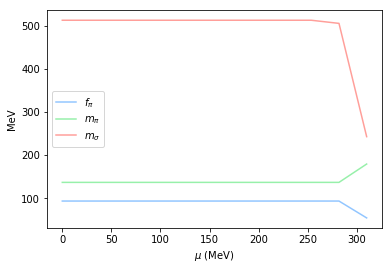

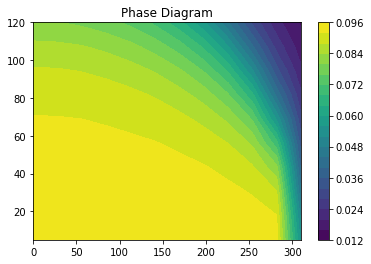

In [ ]:
  # plot results
  from matplotlib.ticker import MaxNLocator
  fig, ax = plt.subplots()
  ax.plot(mu_array*cutoff, min_values[0, :]*cutoff, label='$f_\pi$')
  ax.plot(mu_array*cutoff, m_pi[0, :]*cutoff, label='$m_\pi$')
  ax.plot(mu_array*cutoff, m_sig[0, :]*cutoff, label='$m_\sigma$')
  leg = ax.legend()
  ax.set_ylabel('MeV')
  ax.set_xlabel('$\mu$ (MeV)')
  plt.show()

  mu_ax, T_ax = np.meshgrid(mu_array*cutoff, T_array*cutoff)
  fig, ax1 = plt.subplots(nrows=1)
  min_vals = min_values
  levels = MaxNLocator(nbins=20).tick_values(min_vals.min(),
                                                min_vals.max())
  CS = ax1.contourf(mu_ax, T_ax, min_values, levels=levels)
  fig.colorbar(CS, ax=ax1)
  plt.title('Phase Diagram')
  plt.show()

# The critical endpoint

In [ ]:
  # Calculate phase diagram
  from joblib import Parallel, delayed
  import multiprocessing

  T_min, T_max = 5/cutoff, 20/cutoff
  mu_min, mu_max = 275/cutoff, 320/cutoff
  N_T, N_mu = 10, 20

  T_array = np.linspace(T_min, T_max, N_T)
  mu_array = np.linspace(mu_min, mu_max, N_mu)
  mu_ax, T_ax = np.meshgrid(mu_array, T_array)

  sol = [[None for _ in range(N_mu)] for _ in range(N_T)]
  min_values, m_sig, m_pi = np.zeros([N_T, N_mu]), np.zeros([N_T, N_mu]), np.zeros([N_T, N_mu])

  num_cores = multiprocessing.cpu_count()
  print("number of cores: ", num_cores)
  print("Duration: "+str(time.time()-start)[:2]+" s") 
  for i in range(N_T):
    sol[i] = Parallel(n_jobs=num_cores)(delayed(solve)(T_array[i], mu_array[j]) for j in range(N_mu))
  print(time.time()-start)

number of cores:  2
Duration: 55 s
9186.181025028229


In [ ]:
  from scipy.interpolate import InterpolatedUnivariateSpline as ius

  for i in range(N_T):
    for j in range(N_mu):
      s = construct_potential(xc, sol[i][j][-1]) - expl_sym_br
      #print(s)
      spl = ius(xc, s, k=4)
      cr_pts = spl.derivative().roots()
      cr_pts = np.append(cr_pts, (xc[0], xc[-1]))
      cr_vals = spl(cr_pts)
      min_index = cr_pts[np.argmin(cr_vals)]
      min_values[i, j] = np.sqrt(min_index)
      s2 = construct_potential(xc, sol[i][j][-1])
      spl2 = ius(xc, s2, k=5)
      m_pi[i, j] = np.sqrt(c/min_values[i, j])
      spl_der = spl2.derivative(n=2)
      m_sig[i, j] = np.sqrt(4*min_values[i, j]**2*spl_der(min_index) + m_pi[i, j]**2)
      #print("(T, mu, fpi): "+str((T_array[i], mu_array[j], min_values[i, j]*cutoff)))

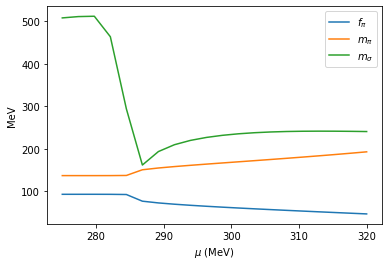

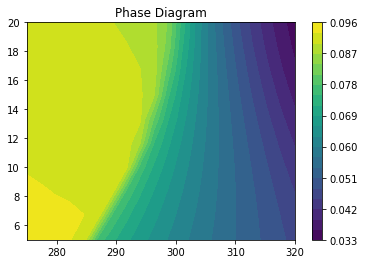

In [ ]:
  # plot results
  from matplotlib.ticker import MaxNLocator
  fig, ax = plt.subplots()
  ax.plot(mu_array*cutoff, min_values[0, :]*cutoff, label='$f_\pi$')
  ax.plot(mu_array*cutoff, m_pi[0, :]*cutoff, label='$m_\pi$')
  ax.plot(mu_array*cutoff, m_sig[0, :]*cutoff, label='$m_\sigma$')
  leg = ax.legend()
  ax.set_ylabel('MeV')
  ax.set_xlabel('$\mu$ (MeV)')
  plt.show()

  mu_ax, T_ax = np.meshgrid(mu_array*cutoff, T_array*cutoff)
  fig, ax1 = plt.subplots(nrows=1)
  min_vals = min_values
  levels = MaxNLocator(nbins=20).tick_values(min_vals.min(),
                                                min_vals.max())
  CS = ax1.contourf(mu_ax, T_ax, min_values, levels=levels)
  fig.colorbar(CS, ax=ax1)
  plt.title('Phase Diagram')
  plt.show()

# Tests: How deep in the IR can you get?

(0.005, 0.0)
342.99736499786377


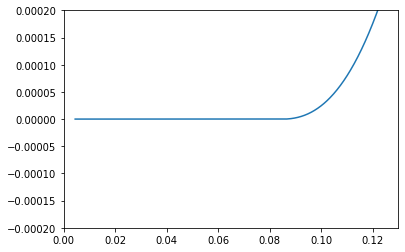

Minimum of the potential:  93.31398608997473
k =  6.737946999085467


In [ ]:
if __name__ == "__main__":
  # All quantities are rendered dimensionless with respect to the cutoff
  cutoff = 1000
  N = 800 # number of gridpoints
  xmax = 180**2/cutoff**2
  x = np.linspace(0, xmax, N+1)
  N_t = 10
  """ increase t_max as much as possible """
  t_max = 5
  t = np.linspace(0, t_max, N_t)

  xc = 0.5*np.array(x[:-1]+x[1:]) # array with values in-between grid points
  xcL = np.append(x[0], xc)
  xcR = np.append(xc, x[-1])
  dx = x[1] - x[0]

  Nf = 4  # N of O(N), not number of flavors
  m_lam, lam, c, h = 794/cutoff, 2, 1750000/cutoff**3, 3.2 # taken from Ref. [1]

  cutoffr = 1  # rescaled cutoff

  u0 = (1/2*m_lam**2 + 1/2*lam*xc) # derivative of initial potential
  v0 = (1.0/2.0*m_lam**2*xc + lam/4.0*xc**2) # initial effective potential
  expl_sym_br = c*np.sqrt(xc) # explicit symmetry breaking term

  start = time.time()  

  sol_example = solve(5/cutoff, 0/cutoff)

  print(time.time()-start)

  # A closer look at the IR potential
  axes = plt.gca()
  axes.set_xlim([0.,.13])
  axes.set_ylim([-0.0002, 0.0002])
  plt.plot(np.sqrt(xc), construct_potential(xc, sol_example[-1]))
  plt.show()
  print("Minimum of the potential: ", np.sqrt(np.argmin(construct_potential(xc, sol_example[-1]) - expl_sym_br)*dx)*1000)
  print("k = ", str(cutoff*np.exp(-t_max)))

# Check Scaling with Gridsize

In [ ]:
from scipy.interpolate import InterpolatedUnivariateSpline as ius

N_range = 20

min_values, m_sig, m_pi = np.zeros([N_range]), np.zeros([N_range]), np.zeros([N_range])

for j in range(1, N_range+1):
  i = j-1
  # All quantities are rendered dimensionless with respect to the cutoff
  cutoff = 1000
  N = 40*j # number of gridpoints
  xmax = 180**2/cutoff**2
  x = np.linspace(0, xmax, N+1)
  N_t = 10
  """ increase t_max as much as possible """
  t_max = 3.5 # This corresponds to roughly k = 2.5 MeV
  t = np.linspace(0, t_max, N_t)

  xc = 0.5*np.array(x[:-1]+x[1:]) # array with values in-between grid points
  xcL = np.append(x[0], xc)
  xcR = np.append(xc, x[-1])
  dx = x[1] - x[0]

  Nf = 4  # N of O(N), not number of flavors
  m_lam, lam, c, h = 794/cutoff, 2, 1750000/cutoff**3, 3.2 # taken from Ref. [1]

  cutoffr = 1  # rescaled cutoff

  u0 = (1/2*m_lam**2 + 1/2*lam*xc) # derivative of initial potential
  v0 = (1.0/2.0*m_lam**2*xc + lam/4.0*xc**2) # initial effective potential
  expl_sym_br = c*np.sqrt(xc) # explicit symmetry breaking term

  start = time.time()  

  sol = solve(5/cutoff, 0/cutoff)

  print(time.time()-start)

  s = construct_potential(xc, sol[-1]) - expl_sym_br
  spl = ius(xc, s, k=4)
  cr_pts = spl.derivative().roots()
  cr_pts = np.append(cr_pts, (xc[0], xc[-1]))
  cr_vals = spl(cr_pts)
  min_index = cr_pts[np.argmin(cr_vals)]
  min_values[i] = np.sqrt(min_index)
  s2 = construct_potential(xc, sol[-1])
  spl2 = ius(xc, s2, k=5)
  m_pi[i] = np.sqrt(c/min_values[i])
  spl_der = spl2.derivative(n=2)
  m_sig[i] = np.sqrt(4*min_values[i]**2*spl_der(min_index) + m_pi[i]**2)

  print("Minimum of the potential: ", min_values[i]*cutoff)
  print("mpi: ", m_pi[i]*cutoff)
  print("msigma: ", m_sig[i]*cutoff)
  #print("k = ", str(1000*np.exp(-t_max)))

(0.005, 0.0)
3.423504114151001
Minimum of the potential:  95.23360448356938
mpi:  135.5576131237497
msigma:  530.4287303114834
(0.005, 0.0)
9.907472372055054
Minimum of the potential:  94.30593735446038
mpi:  136.2227070053465
msigma:  516.3657789196307
(0.005, 0.0)
18.659502744674683
Minimum of the potential:  93.98790261834183
mpi:  136.4529864560133
msigma:  512.5084162017467
(0.005, 0.0)
29.686097860336304
Minimum of the potential:  93.82703780609177
mpi:  136.56990948900483
msigma:  511.6542042708501
(0.005, 0.0)
42.88495326042175
Minimum of the potential:  93.73021148737914
mpi:  136.64043183204026
msigma:  511.20046831782486
(0.005, 0.0)
54.19831323623657
Minimum of the potential:  93.66549957469593
mpi:  136.68762496621727
msigma:  510.8795338248432
(0.005, 0.0)
79.91090059280396
Minimum of the potential:  93.61920247307751
mpi:  136.7214185604792
msigma:  510.6491795976267
(0.005, 0.0)
121.58836960792542
Minimum of the potential:  93.58443923945723
mpi:  136.74680973316924
msi

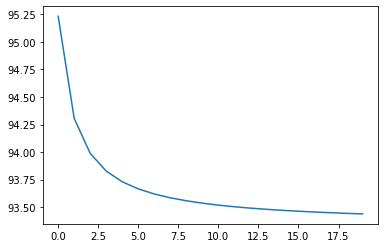

In [ ]:
plt.plot(min_values*cutoff)

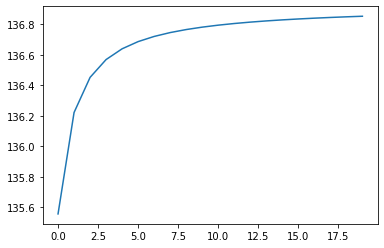

In [ ]:
plt.plot(m_pi*cutoff)

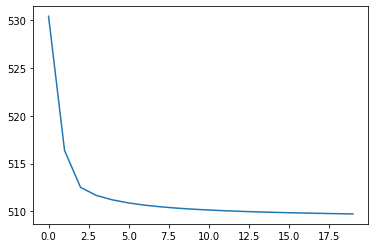

In [ ]:
plt.plot(m_sig*cutoff)